<a href="https://colab.research.google.com/github/nladocsi/pca_assignment/blob/main/pca_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [9]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()


Plot a histogram of the occurrences
of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?
*   In the histogram below I can see that there is a big drop from the left to the right. This indicates that there is a larger number of tokens that occur only once or a few times.
*   As the frequency of tokens increases the number of tokens that have that frequency decreases.
*   This is a typical trend as when you complie a large amount of "natrual language" the freqeuncy of words is inversely proportional to the rank (how high a word is on the list when sorted by frequency) of said word.
*   For example, the most frequent work gets rank 1.


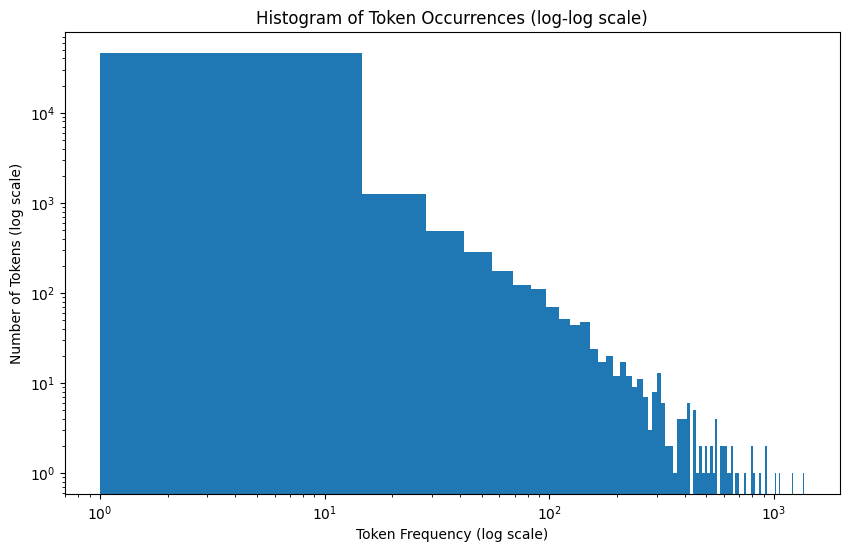

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(list(token_count.values()), bins=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Token Frequency (log scale)')
plt.ylabel('Number of Tokens (log scale)')
plt.title('Histogram of Token Occurrences (log-log scale)')
plt.show()

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? **Intervention, localizaed, thermal, crawler, background-image**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_parquet('Phishing_clean.parquet')
#print(df.head())

In [3]:
#2.1
X = df.drop(columns=['Email Type'])
y = df['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#2.2
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print("Training R^2:", r2_train)
print("Testing R^2:", r2_test)


Training R^2: 0.7670143724934355
Testing R^2: 0.6658718438847919


In [5]:
#2.3
coef_df = pd.DataFrame({
    'token': X.columns,
    'coefficient': model.coef_
})

# Sort by absolute value
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
top_tokens = coef_df.sort_values('abs_coef', ascending=False).head(15)

print(top_tokens)

                  token  coefficient  abs_coef
835        intervention    -1.259257  1.259257
740           localized     0.824350  0.824350
2362            thermal     0.747006  0.747006
851             crawler     0.696167  0.696167
1504  background-image:    -0.622909  0.622909
1406         helvetica,     0.598560  0.598560
906               aging     0.594956  0.594956
1839              form.     0.576886  0.576886
2242              gray;    -0.574480  0.574480
1552           a:active     0.574480  0.574480
1494         retrieving    -0.573761  0.573761
2657              zdnet    -0.560954  0.560954
1245  {text-decoration:     0.497075  0.497075
2532             xanaax     0.491981  0.491981
2566         transcript     0.488978  0.488978


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(X)
X_pca = pca.transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['Email Type'] = y.values
print(X_pca_df.head())

        PC1       PC2  Email Type
0 -0.009876 -0.075963           0
1 -0.022726 -0.005866           0
2 -0.044885  0.439279           0
3 -0.088179  0.201641           1
4 -0.075705  0.116032           1


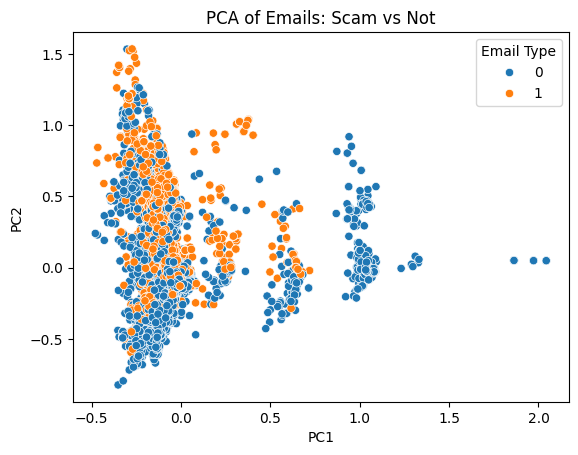

In [11]:
sns.scatterplot(data=X_pca_df,x='PC1', y='PC2',hue='Email Type')
plt.title('PCA of Emails: Scam vs Not')
plt.show()

**Question 3 patterns:**
*   As visualized in the scatter plot, there is overlap between the two components on the left hand side of the plot. This observation explains that the scam emails and the non-scam emails do have some similar features.
*   Interestingly, there are also clusters that appear within this plot, towards the right side.
*   Within the clusters on the right the points are mainly blue this signifies that there are some distinctive characters found in emails that are not scams.
*   With just two principal components there doesn't appear to be a clear separation.




### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

Overall the PCA approach is slightly better. Comparing the R^2 values there is a 0.4% improvement within the test R^2. The PCA model has a smaller train-test gap therefore it generalizes better and reduces overfitting.

In [16]:
pca = PCA(n_components = 2610)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

y_pred_train_pca = model_pca.predict(X_train_pca)
y_pred_test_pca = model_pca.predict(X_test_pca)

r2_train_pca = model_pca.score(X_train_pca, y_train)
r2_test_pca = model_pca.score(X_test_pca, y_test)

print("PCA Training R^2:", r2_train_pca)
print("PCA Testing R^2:", r2_test_pca)

PCA Training R^2: 0.7662326827745849
PCA Testing R^2: 0.6683390643101164


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

When using the principal componenets to run a regression there are a few advantages. First PCA is able to group together features that occur commonly together, compared to the original linear regression where the model may get confused distinguishing between the commonly appearing words. With the first data set where punctuation and words like "the" may not be significant for scam detection. Also with over 2,000 tokens words like this often can be seen as noise and by dropping them it allows the model to focus on the real patterns in the data. We have also talked about overfitting and with less features the overfitting decreases.